In [77]:
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [78]:
data = None
with open("benchmark_results.yaml") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [79]:
from uncertainties import unumpy
implementations = [key for key in data["200.yaml"]]
grid_sizes = [int(key.split(".")[0]) for key in data]
grid_sizes.sort()

def to_key(size):
    return "{}.yaml".format(size)

implementations_dict = {}

for implementation in implementations:
    median = []
    mean = []
    max = []
    min = []
    std = []
    
    for size in grid_sizes:
        if(implementation in data[to_key(size)]):
            times = data[to_key(size)][implementation]["time"]
            
            median.append(times["median"])
            mean.append(times["mean"])
            min.append(times["min"])
            max.append(times["max"])
            std.append(times["std"])
            
            
    implementations_dict[implementation] = {
        "median" : np.array(median),
        "mean" : np.array(mean),
        "max" : np.array(max),
        "min" : np.array(min),
        "std" : np.array(std)
    }
    
baseline = "cpp_naive"
baselines_times = unumpy.uarray(implementations_dict[baseline]["mean"], implementations_dict[baseline]["std"])

for implementation in implementations_dict:
    print(implementation)
    min_length = np.min([implementations_dict[implementation]["mean"].size, implementations_dict[baseline]["mean"].size])
    implementation_times = unumpy.uarray(implementations_dict[implementation]["mean"][:min_length], implementations_dict[implementation]["std"][:min_length])
    speedup = baselines_times[:min_length] / implementation_times
    implementations_dict[implementation]["mean_speedup"] = unumpy.nominal_values(speedup)
    implementations_dict[implementation]["std_speedup"] = unumpy.std_devs(speedup)
    

pytorch_conv
julia_parallel_stencil_8_threads
julia_cuda_stencil
julia_parallel_stencil
numpy_array
cpp_cuda_stencil
python_lists
julia_cuda_array
pytorch_array
julia_sequential_array
julia_parallel_stencil_24_threads
cpp_naive
julia_sequential_stencil
julia_parallel_stencil_12_threads


/home/daniel/anaconda3/envs/i2dl/lib/python3.10/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


In [93]:
implementations_dict["julia_parallel_stencil"]["label"] = "Julia parallel stencil 4 threads"
implementations_dict["julia_parallel_stencil_8_threads"]["label"] = "Julia parallel stencil 8 threads"
implementations_dict["julia_parallel_stencil_12_threads"]["label"] = "Julia parallel stencil 12 threads"
implementations_dict["julia_parallel_stencil_24_threads"]["label"] = "Julia parallel stencil 24 threads"
implementations_dict["pytorch_array"]["label"] = "Pytorch array programming"
implementations_dict["julia_sequential_array"]["label"] = "Julia array programming sequential"
implementations_dict["numpy_array"]["label"] = "Numpy array programming"
implementations_dict["cpp_cuda_stencil"]["label"] = "CUDA-C kernel"
implementations_dict["python_lists"]["label"] = "sequential implementation in Python"
implementations_dict["pytorch_conv"]["label"] = "Pytorch Conv2d layer with stencil weights"
implementations_dict["julia_sequential_stencil"]["label"] = "Julia sequential stencil code"
implementations_dict["julia_cuda_stencil"]["label"] = "CUDA.jl stencil"
implementations_dict["julia_cuda_array"]["label"] = "CUDA.jl array programming"
implementations_dict["cpp_naive"]["label"] = "Naive sequential C++ implementation"

implementations_dict["julia_parallel_stencil"]["color"] = "thistle"
implementations_dict["julia_paralel_stencil"]["marker"] = 
implementations_dict["julia_parallel_stencil_8_threads"]["color"] = "plum"
implementations_dict["julia_parallel_stencil_12_threads"]["color"] = "violet"
implementations_dict["julia_parallel_stencil_24_threads"]["color"] = "purple"

implementations_dict["pytorch_array"]["color"] = "lightcoral"
implementations_dict["pytorch_conv"]["color"] = "firebrick"

implementations_dict["julia_sequential_array"]["color"] = "blue"
implementations_dict["julia_sequential_stencil"]["color"] = "darkturquoise"

implementations_dict["cpp_naive"]["color"] = "black"

implementations_dict["numpy_array"]["color"] = "gold"
implementations_dict["python_lists"]["color"] = "cornflowerblue"

implementations_dict["cpp_cuda_stencil"]["color"] = "chartreuse"
implementations_dict["julia_cuda_array"]["color"] = "darkgreen"
implementations_dict["julia_cuda_stencil"]["color"] = "limegreen"

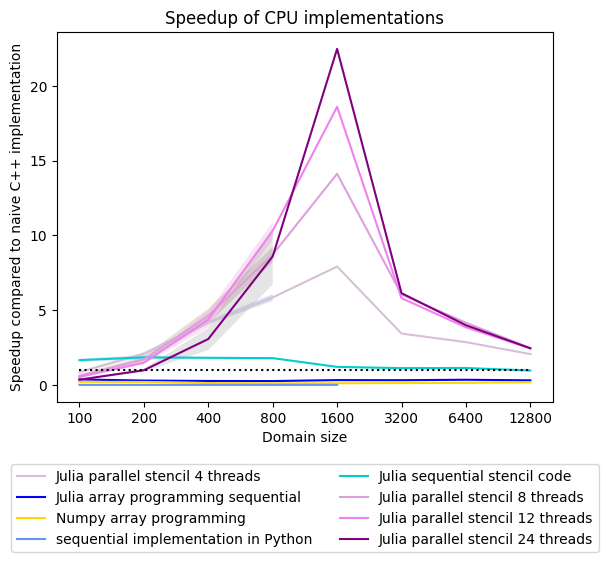

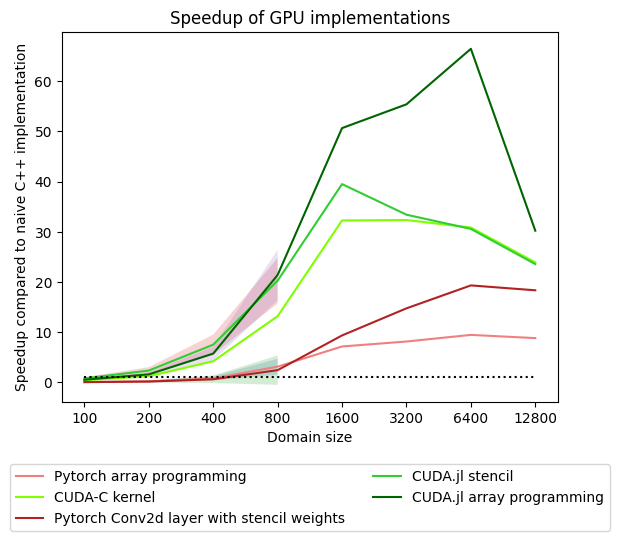

In [94]:
def plot_implementations(implementations, data_dict, category="mean_speedup"):
    max_x = 0
    max_y = 0
    
    for implementation in implementations:
        data = data_dict[implementation][category]
        space = np.linspace(1, data.size, data.size)
        plt.plot(space, data, label=implementations_dict[implementation]["label"], color=implementations_dict[implementation]["color"])
        plt.fill_between(space, data - data_dict[implementation]["std_speedup"], data + data_dict[implementation]["std_speedup"], alpha=0.2)
        max_x = np.max([max_x, space.size])
        max_y = np.max([max_y, np.max(data)])
        
    plt.xticks(np.linspace(1, 8, 8), grid_sizes)
    plt.xlabel("Domain size")
    plt.ylabel("Speedup compared to naive C++ implementation")
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.plot([1, max_x], [1, 1], c="black", linestyle="dotted")
        
cpu_implementations = ["julia_parallel_stencil", "julia_sequential_array", "numpy_array", "python_lists", "julia_sequential_stencil", "julia_parallel_stencil_8_threads", "julia_parallel_stencil_12_threads", "julia_parallel_stencil_24_threads"]
gpu_implementations = ["pytorch_array", "cpp_cuda_stencil", "pytorch_conv", "julia_cuda_stencil", "julia_cuda_array"]
   
plt.title("Speedup of CPU implementations")     
plot_implementations(cpu_implementations, implementations_dict)
plt.savefig("figures/speedup_cpu_implementations.pdf",bbox_inches='tight')
plt.show()

plt.title("Speedup of GPU implementations")
plot_implementations(gpu_implementations, implementations_dict)
plt.savefig("figures/speedup_gpu_implementations.pdf",bbox_inches='tight')
plt.show()

In [15]:
sp_compute = 2150
dp_compute = sp_compute / 2

plt.loglog(x, y)
plt.xlim([100, 10000])
plt.ylim([100, 10000])

#sp ideal cache
x = [0, 3440, 10000]
y = [0, sp_compute, sp_compute]

#dp ideal cache
x = [0, 3440, 10000]
y = [0, dp_compute, dp_compute]
plt.loglog(x, y)

#sp cache agnostic no full row fits in cache
x = [0, 6880, 10000]
y = [0, sp_compute, sp_compute]
plt.loglog(x, y)

NameError: name 'x' is not defined

{'median': array([1.54092893e-01, 1.64398007e-01, 1.76982318e-01, 2.39111425e-01,
       5.19660017e-01, 7.40212464e+00, 5.13910322e+01, 3.11832815e+02]), 'mean': array([1.58762403e-01, 1.68821227e-01, 1.93446081e-01, 2.68585186e-01,
       5.15338174e-01, 7.43416294e+00, 5.10471039e+01, 3.07354639e+02]), 'max': array([2.43111001e-01, 2.46595869e-01, 3.38095896e-01, 4.12731286e-01,
       6.64656394e-01, 7.97473956e+00, 5.21721830e+01, 3.17308058e+02]), 'min': array([1.45870732e-01, 1.56363273e-01, 1.67876535e-01, 2.14942515e-01,
       4.12801628e-01, 7.01144898e+00, 4.97567782e+01, 2.92923043e+02]), 'std': array([ 0.01695242,  0.01651213,  0.04628356,  0.05861845,  0.07580171,
        0.39123212,  0.96027587, 12.79444321]), 'mean_speedup': array([ 0.34993508,  0.98060265,  3.06842691,  8.59206809, 22.47172945,
        6.13497866,  3.9908054 ,  2.44710077]), 'std_speedup': array([0.03897556, 0.09911228, 0.73434312, 1.87717544,        nan,
              nan,        nan,        nan]), '

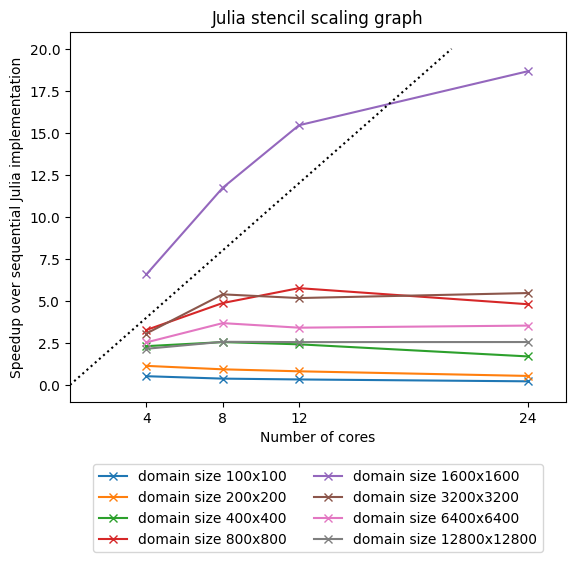

In [69]:
data24 = implementations_dict["julia_parallel_stencil_24_threads"]
print(data24)
data12 = implementations_dict["julia_parallel_stencil_12_threads"]
data8 = implementations_dict["julia_parallel_stencil_8_threads"]
data4 = implementations_dict["julia_parallel_stencil"]

baseline_data = implementations_dict["julia_sequential_stencil"]["mean"]

scaling_list = [data4, data8, data12, data24]
core_counts = [4, 8, 12, 24]
domains = [100, 200, 400, 800, 1600, 3200, 6400, 12800]

for domain, i in zip(domains, range(len(domains))):
    data = []
    for cc in scaling_list:
        data.append(baseline_data[i] / cc["mean"][i])
    plt.plot(core_counts, data, label="domain size {}x{}".format(domain, domain), marker="x")
    
plt.xticks(core_counts)
plt.title("Julia stencil scaling graph")
plt.xlabel("Number of cores")
plt.ylabel("Speedup over sequential Julia implementation")
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)

plt.xlim([0, 26])

plt.plot([0, 20], [0, 20], color="black", linestyle="dotted")
    
plt.savefig("figures/cpu_scaling.pdf",bbox_inches='tight')

Text(0.5, 1.0, 'Roofline analysis of CPU implementations')

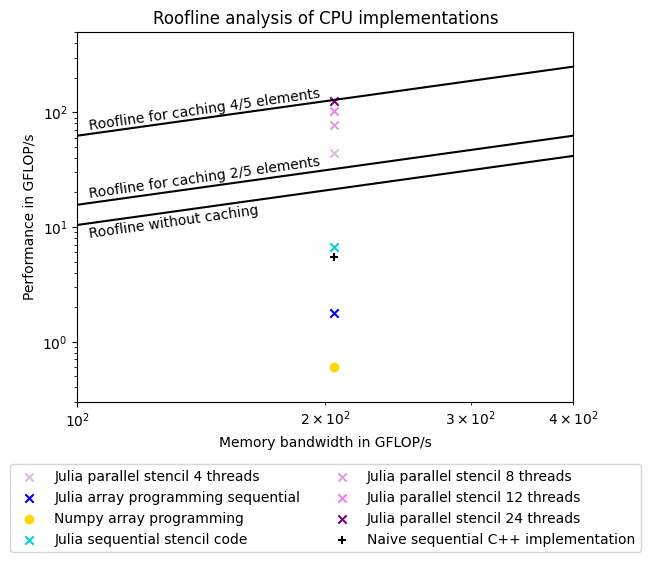

In [96]:
domain = 1600
flops = domain*domain*5*5000

ax=plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")

# no caching
plt.plot([1, 10320], [5/48, 1075], color="black")

# caching two elements
plt.plot([1, 6880], [5/32, 1075], color="black")

# caching all elements except one
plt.plot([1, 1720], [5/8, 1075], color="black")

markers = ["x", "x", "o", "o", "x", "x", "x", "x", "+"]

for implementation, i in zip(cpu_implementations + ["cpp_naive"], range(len(cpu_implementations) + 1)):
    if implementation != "python_lists":
        plt.scatter(204.8, flops / implementations_dict[implementation]["mean"][4] * 1e-9, label=implementations_dict[implementation]["label"], marker=markers[i], color=implementations_dict[implementation]["color"])

plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    
plt.xlabel("Memory bandwidth in GFLOP/s")
plt.ylabel("Performance in GFLOP/s")

plt.xlim([100, 400])
plt.ylim([.3, 500])

plt.text(103, 70, "Roofline for caching 4/5 elements", rotation=8)
plt.text(103, 18, "Roofline for caching 2/5 elements", rotation=8)
plt.text(103, 8, "Roofline without caching", rotation=8)
plt.title("Roofline analysis of CPU implementations")